In [1]:
from PIL import Image
import numpy as np
import pickle

In [2]:
def load_data(pack):
    with open(f'{pack}.pkl', 'rb') as file:
        data = pickle.load(file)
    return data

In [49]:
def correct_filename(filename, default='png'):
    """
    Verify that the filename is valid:
    - if there is no extension in the end of the 
      filename, the default extension will be added;
    - if filename has unsupported extension, it will
      be replaced by the default extension.
    """
    # Set of all supported by PIL extensions
    supported = {ex[1:] for ex, f 
                 in Image.registered_extensions().items() 
                 if f in Image.OPEN}

    sep = filename.split('.')
    if len(sep) == 1 or sep[-1] not in supported:
        # If there is no extension or it is unsupported
        return f'{filename}.{default}'
    else:
        # If filename is valid
        return filename

In [63]:
def draw(image, width, 
         save_as=None,
         pack='data/colors', 
         styles='all', 
         background=(0, 0, 0)):
    """
    The main method for create emoji arts

    PARAMETERS
    ----------
    image : str
        path to source image
    
    width : int
        number of emojis in width
    
    save_as : str or None
        path to save the result. If None is specified,
        result will not be saved
    
    styles : str
        each letter stands for emoji styles which will
        be used in art:
        't' = Twitter emoji;
        'a' = Apple emoji;
        'g' = Google emoji;
        'f' = Facebook emoji.
        For example, styles='ag' means that Apple and 
        Google emoji styles will be used. If 'all' is
        specified, it will be replaced by 'tagf'.
    
    background : (int, int, int, [int]) or None or 'auto'
        the color of background:
        - tuple of 3 ints and 4 ints specifies RGB and RGBA 
          colors for background respectively;
        - if None is specified, transparent background will
          be applied (same effect as with alpha = 0 in RGBA);
        - if 'auto' is specified, the most suitable background
          for each emoji will be chosen (but it can take a lot 
          of time).
    """    
    data = load_data(pack)
    esize = data['size']

    # Creating indices for filter styles in RGBA matrices
    if styles == 'all' or not isinstance(styles, str):
        styles = 'tagf'
    style_indices = [i for i in range(4) 
                     if 'tagf'[i] in styles]
    if not style_indices:
        style_indices = [*range(4)]
    # Leave only data for specified styles
    matrices = data['matrices'][style_indices]

    # Preparing source image
    source = Image.open(f'{image}').convert('RGBA')
    # Reducing image size and leave only RGB channels
    source.thumbnail((width, -1))
    source_w, source_h = source.size
    # Result emoji art image size
    result_h, result_w = source_h * esize, source_w * esize

    # Get alpha values of RGBA pixels
    alphas = matrices[..., 3:] / 255

    # Add background to RGBA matrices
    if len(background) == 4 and background[-1] == 0:
        background = None
    if background is not None and background != 'auto':
        # Preparing background color
        b_color = np.array([0, 0, 0, 255], dtype='uint8')
        b_color[:len(background)] = background
        b_alpha = b_color[-1] / 255
        # Applying backgound to emojis
        matrices = matrices * alphas + b_color * b_alpha * (1 - alphas)
        matrices /= (result_alpha := alphas + b_alpha * (1 - alphas))
        matrices[..., 3:] = result_alpha * 255
        matrices = np.round(matrices).astype('uint8')
        # Update alpha values after applying backgound
        alphas = matrices[..., 3:] / 255
    
    # Calculate average colors of emojis
    weighted_sum = (matrices[..., :3] * alphas).sum(axis=(-2, -3))
    averages = weighted_sum / alphas.sum(axis=(-1, -2, -3))[..., None]

    # Transform source image to numpy array
    source = np.array(source)
    
    # Indices of the emojis having nearest average colors
    best_i = (averages.reshape(-1, 3) - source[..., None, :3]) ** 2
    best_i = best_i.sum(axis=-1).argmin(axis=-1)
    # Get the most suitable emojis by indices
    result = matrices.reshape(-1, *matrices.shape[2:])[best_i]

    if background == 'auto':
        # Alpha-value of RGBA of each pixel in result
        alphas = result[..., 3:] / 255
        # Calculate areas occupied by an emojis in result
        areas = alphas.sum(axis=(-1, -2, -3)) / esize / esize
        areas = areas[..., None, None, None]
        # Calculate the most suitable background colors for emojis
        tiles = (source[..., None, None, :] - areas * result) / (1 - areas)
        tiles = np.clip(tiles, 0, 255)
        # Applying backgounds to each emoji
        result = result * alphas + tiles * (1 - alphas)
        result[..., 3] = 255
        result = np.round(result).astype('uint8')
    
    # Reshaping to result size
    result = result.transpose(0, 2, 1, 3, 4).reshape(result_h, result_w, 4)
    result_image = Image.fromarray(result)

    # Saving the result if necessary
    if isinstance(save_as, str):
        filename = correct_filename(save_as)
        result.save(f'{filename}')
        print(f'The result was saved in {filename}')
    
    return result_image

CPU times: user 707 ms, sys: 223 ms, total: 930 ms
Wall time: 959 ms


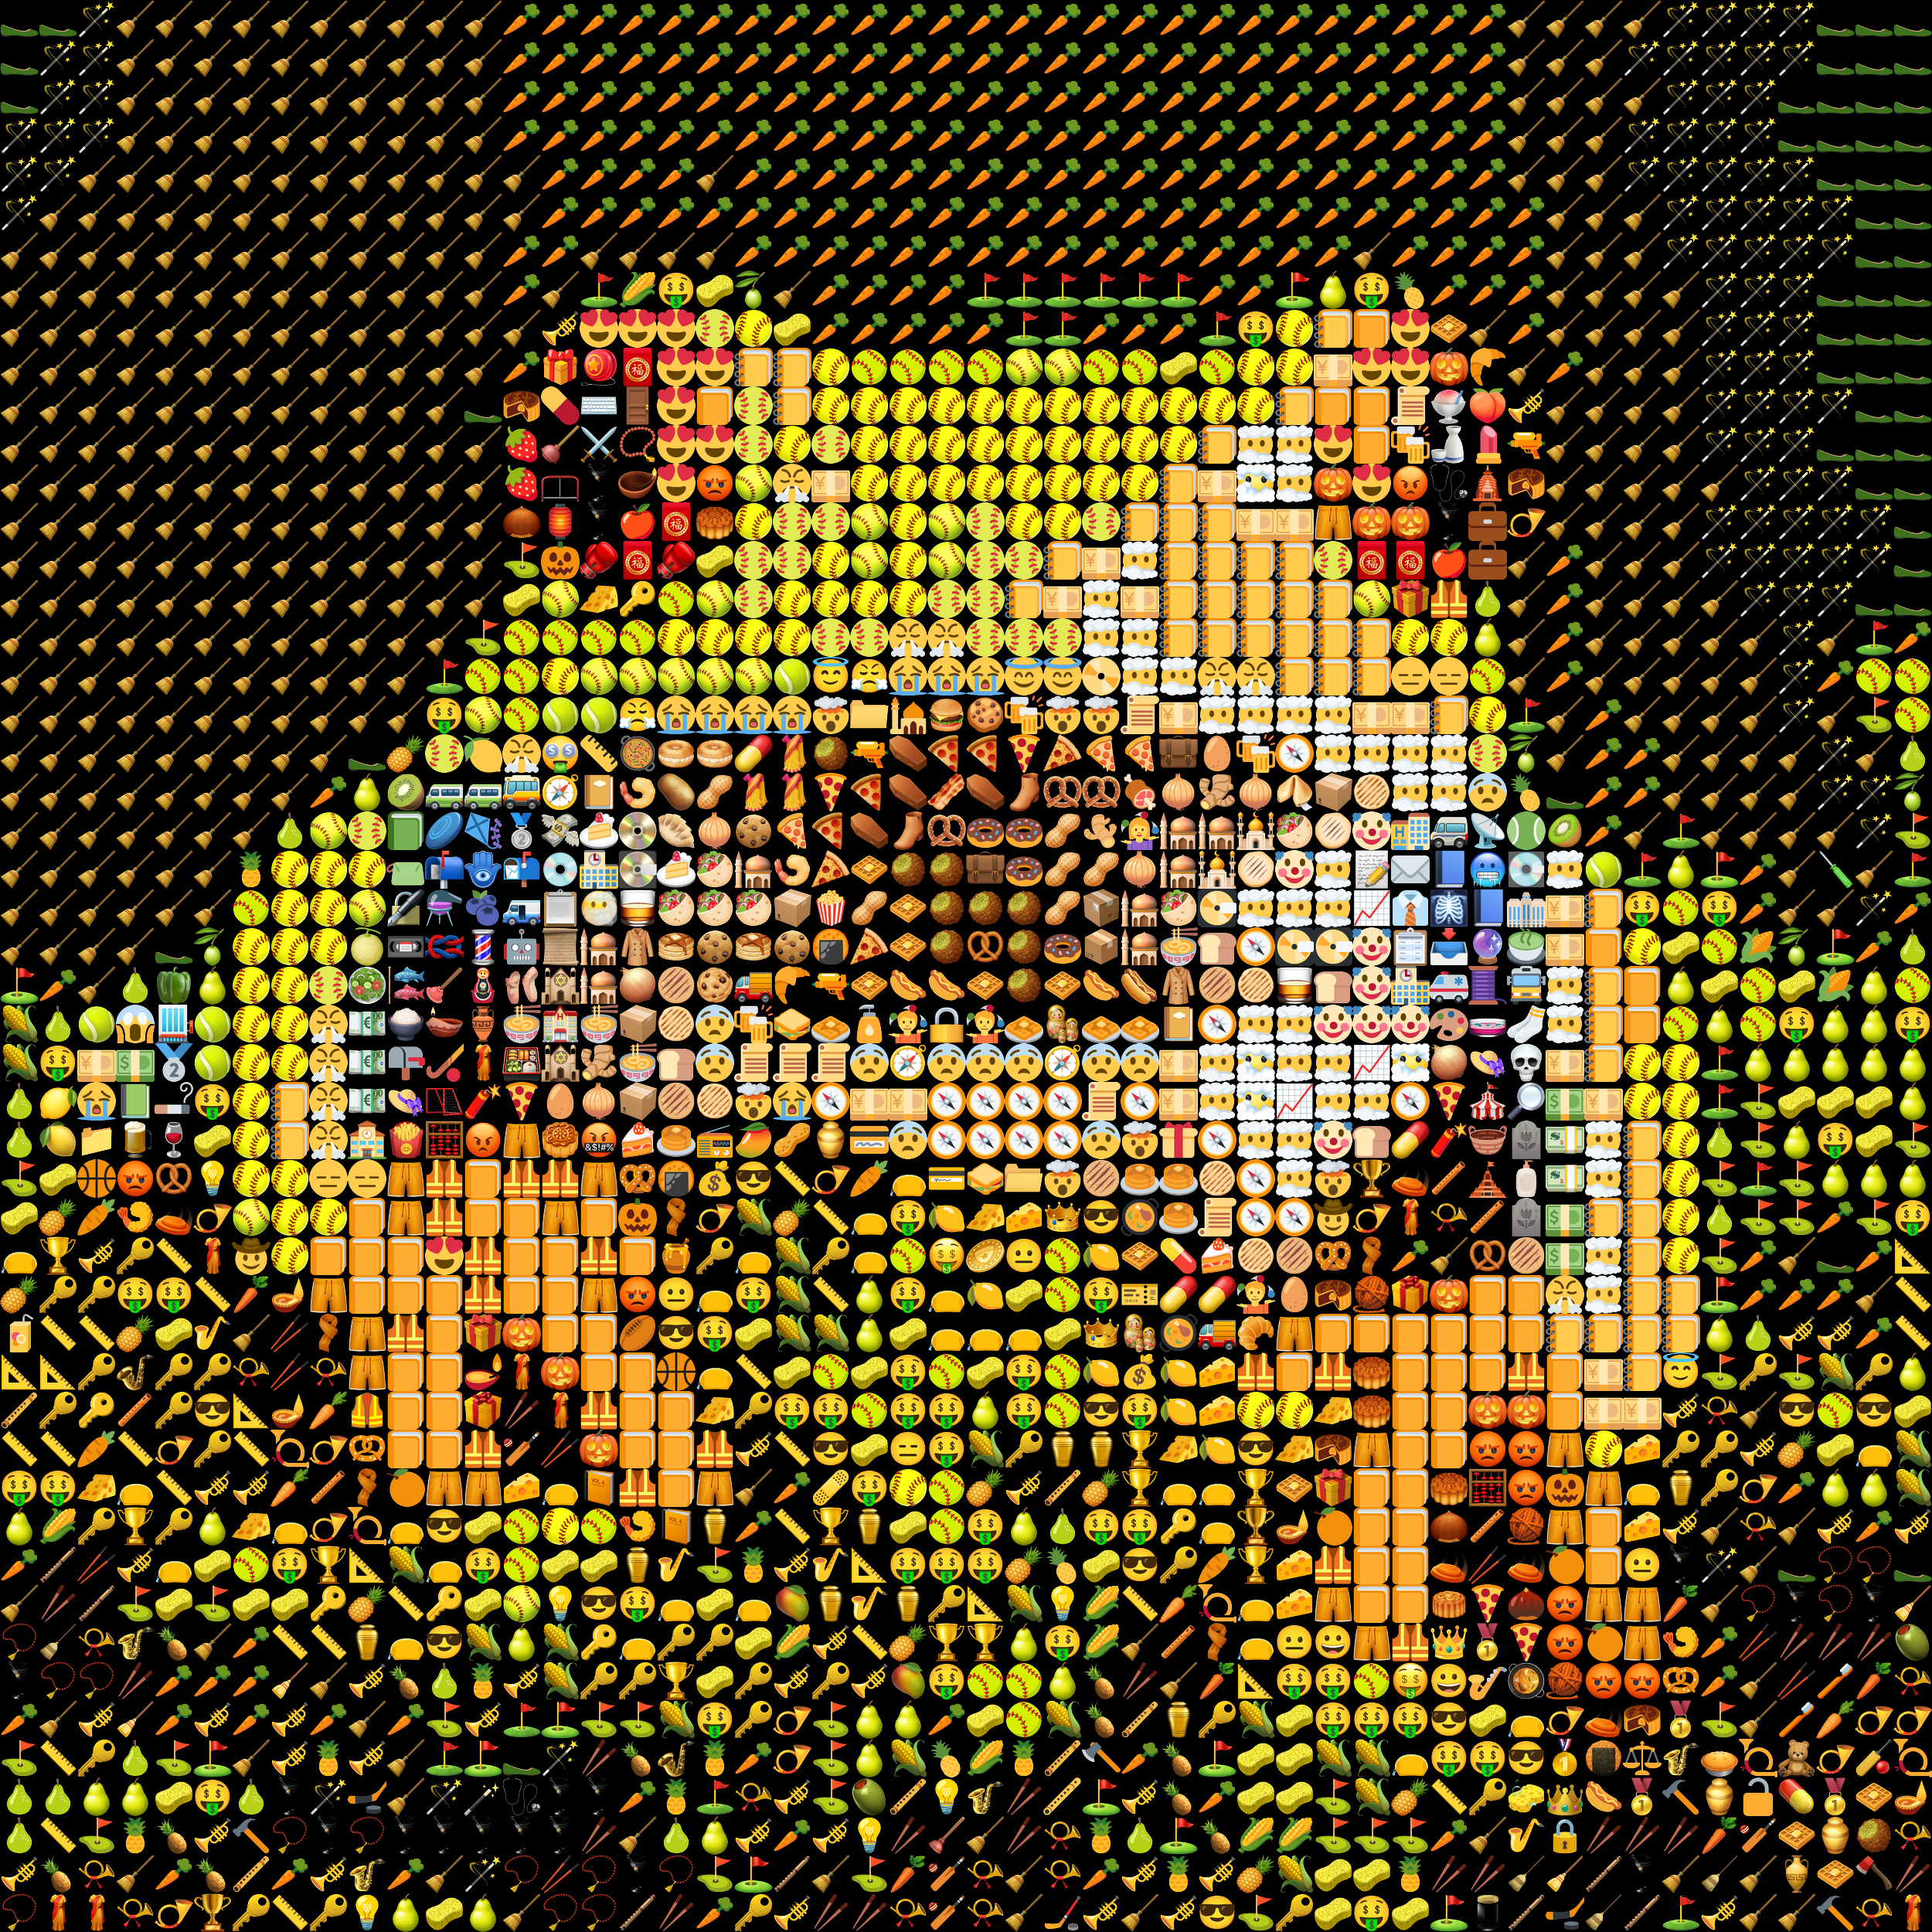

In [67]:
%%time
img = draw('images/frog.png', 50,
           pack='data/classic', 
           # styles='a',
           # background=(255, 255, 255),
           # background='auto',
           # background=None,
          )
img